# Retirement Burndown Simulation Model

This model will project future retirement incomes and "nest egg" savings levels starting from the date of retirement

Limitations

-
This model only calculates values yearly, and all withdrawals are made before the market returns of that year
-
This model can only simulate up to 91 years due to prohibition of resampling historical data

Assumptions

-
Inflation is a constant value applied per year to necessary retirement income & Social Security income
-  
Investments in stock will track the S&P 500
-   
Investments in "bonds" will track short-yield treasury bill rates, but historical data on this is inconsistent, so yields before 1962 are 3mo/6mo treasuries, while yields from 1962 and after are 1-year treasuries
-   
Every year's market returns are randomly sampled from past annual market returns, resampling is not allowed.

### Set user-defined simulation conditions 

In [1]:
total_savings=9000000
time_horizon=50 #in years after retirement
retirement_age=66
pension=0 #annual pension, does not increase with inflation
starting_social_security=80000 #Social security benefit in the first year you receive it, increases with inflation
social_security_age=67 #Age when you intend to start taking social security benefits
inflation=1.03 #constant
starting_retirement_income=300000 #Income needed in first year of retirement, increases with inflation

stock_allocation=.70 #total sp500 returns 1931-2022
bond_allocation=.29 #short term treasury bill returns 1931-2022
cash_allocation=.01 #no appreciation

### Import libraries

In [2]:
import pandas as pd
import numpy as np
import random
import datetime
import time
import os
from functools import partial
import multiprocess as mp
from itables import init_notebook_mode
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

### Define functions 

In [3]:
#helper function for date processing
def fix_date(x):
    if x.year > 2023:
        year = x.year - 100
    else:
        year = x.year
    return(year)
    
#Define a simulation function 
def retirement_sim(run,dict_params,seed):
    
    #setup... unpack the parameters
    time_horizon=dict_params.get('time_horizon')
    retirement_age=dict_params.get('retirement_age')
    total_savings=dict_params.get('total_savings')
    starting_retirement_income=dict_params.get('starting_retirement_income')
    temp_historical_returns=dict_params.get('historical_returns')
    inflation=dict_params.get('inflation')
    starting_social_security=dict_params.get('starting_social_security')
    social_security_age=dict_params.get('social_security_age')
    pension=dict_params.get('pension')
    
    #for every year...
    for i in range(time_horizon+1):
        
        age=retirement_age+i
        
        #special setup for starting retirement
        if i==0:
            #set indicator to false
            bust=False
            ending_savings=total_savings
            #first row of data just shows starting value at retirement
            sim_rows=[pd.DataFrame(data={'run':run,'year':i,'age':age,
                                               'ending_savings':ending_savings,'income':None,
                                               'social_security':None,'sp500_return':None,
                                               'bond_return':None,'portfolio_return':None,
                                               'sampled_return_year':None,'bust':None},index=[i])]
            
        else:
            
            #first, figure out what your social security should be
            if age>social_security_age:
                social_security=starting_social_security*(inflation**(age-social_security_age-1))
            else:
                social_security=0
            
            #set your guaranteed income for the year
            guaranteed_income=social_security+pension

            #if you've already run out of money!...
            if bust==True:
                ending_savings=0
                income=guaranteed_income
                #write the next row of data
                sim_rows.append(pd.DataFrame(data={'run':run,'year':i,'age':age,
                        'ending_savings':ending_savings,'income':income,
                        'social_security':social_security,'sp500_return':None,
                        'bond_return':None,'portfolio_return':None,
                        'sampled_return_year':None,'bust':bust},index=[i]))
                #just go to the next year of retirement - you're still out of money!
                continue
            
            #If you're not out of money...
            starting_savings=ending_savings
            income=starting_retirement_income*(inflation**(i-1))

            #sample a random year of returns and compute weighted portfolio returns
            sampled_returns=temp_historical_returns.sample(1,random_state=run+seed)
            temp_historical_returns=temp_historical_returns.drop(sampled_returns.index)
            sampled_return_year=sampled_returns['year'].squeeze()
            sp500_return=sampled_returns['sp500_return'].squeeze()
            tbill_return=sampled_returns['tbill_return'].squeeze()
            portfolio_return=sp500_return*stock_allocation+tbill_return*bond_allocation+cash_allocation
            
            #calculate ending savings after this year
            ending_savings=(starting_savings-(income-guaranteed_income))*portfolio_return
            
            #check to see if you've run out of money this year
            if ending_savings<=0:
                bust=True
                ending_savings=0
                income=starting_savings+guaranteed_income
            
            #write the next row of data
            sim_rows.append(pd.DataFrame(data={'run':run,'year':i,'age':age,
                    'ending_savings':ending_savings,'income':income,
                    'social_security':social_security,'sp500_return':sp500_return,
                    'bond_return':tbill_return,'portfolio_return':portfolio_return,
                    'sampled_return_year':sampled_return_year,'bust':bust},index=[i]))
    
    #put all the rows of data together!
    df_sim=pd.concat(sim_rows)
    return(df_sim)

### Read historical data to populate model 

In [4]:
#get the current working directory
wd=os.getcwd()

#read in historical returns and clean data
#S&P 500
#https://www.fool.com/investing/stock-market/indexes/sp-500/annual-returns/
historical_sp500=pd.read_csv(f'{wd}/sp500_total_returns.csv') 
historical_sp500['sp500_return']=historical_sp500['Total Return (Dividends Reinvested)']+1
historical_sp500['year']= historical_sp500['Year']

#1-year US treasury 
#https://fred.stlouisfed.org/series/RIFLGFCY01NA
historical_1year=pd.read_csv(f'{wd}/1yr_tbill_returns.csv') 
historical_1year['tbill_return']=historical_1year['RIFLGFCY01NA']/100+1
historical_1year['year']=pd.to_datetime(historical_1year['DATE']).apply(fix_date)
historical_1year=historical_1year[['year','tbill_return']]

#3-6 month US treasury
#https://fred.stlouisfed.org/series/M1329BUSM193NNBR
historical_3mo_6mo=pd.read_csv(f'{wd}/3mo_6mo_treasury_yields.csv')
historical_3mo_6mo['tbill_return']=historical_3mo_6mo['M1329BUSM193NNBR']/100+1
historical_3mo_6mo['year']=pd.to_datetime(historical_3mo_6mo['DATE']).apply(fix_date)
historical_3mo_6mo=pd.DataFrame(historical_3mo_6mo.groupby('year')['tbill_return'].mean().reset_index())
historical_3mo_6mo=historical_3mo_6mo[historical_3mo_6mo['year']<1962]

#combine US treasuries
historical_tbill=pd.concat([historical_3mo_6mo,historical_1year])

#merge the datasets together
historical_returns=historical_tbill.merge(historical_sp500,on='year')[['year','tbill_return','sp500_return']]

### Finalize simulation setup 

In [5]:
#fix allocations if allocation sum != 1
total_allocation=stock_allocation+bond_allocation+cash_allocation
if total_allocation != 1:
    print('WARNING: Your total allocation does not sum to 1... normalizing')
    stock_allocation=stock_allocation/total_allocation
    bond_allocation=bond_allocation/total_allocation
    cash_allocation=cash_allocation/total_allocation  

#set up parameter dictionary to make passing to function easier
dict_params={'time_horizon':time_horizon,
             'retirement_age':retirement_age,
             'total_savings':total_savings,
             'starting_retirement_income':starting_retirement_income,
             'historical_returns':historical_returns,
             'inflation':inflation,
             'starting_social_security':starting_social_security,
             'social_security_age':social_security_age,
             'pension':pension,
            'stock_allocation':stock_allocation,
            'bond allocation':bond_allocation,
            'cash_allocation':cash_allocation}

### Run the model 

In [7]:
#set the number of runs and the random seed you want
nrun=5000
seed=1

############################ MULTIPROCESS #############################################
#On my macbook, this runs about 25 sims per second
run_list=list(range(1,nrun+1))

start=time.time()
with mp.Pool(processes=mp.cpu_count()) as pool:
        results = list(tqdm(pool.imap(partial(retirement_sim, dict_params=dict_params, seed=seed), run_list), total=nrun))
        
master_df=pd.concat(results)
end=time.time()
print(f'Multiprocess executed {nrun} sims in {int(end-start)} seconds.')


  0%|          | 0/5000 [00:00<?, ?it/s]

Multiprocess executed 5000 sims in 287 seconds.


### Process simulation data

In [8]:
#clean the simulation data and prep for plotting
plotme=master_df.copy()
plotme['ending_savings']=plotme['ending_savings']/1000000
plotme['bust'].fillna(0, inplace=True)
bust_plot=pd.DataFrame(plotme.groupby('age')['bust'].mean()).reset_index()
bust_plot['bust']=bust_plot['bust']*100

### Plot results

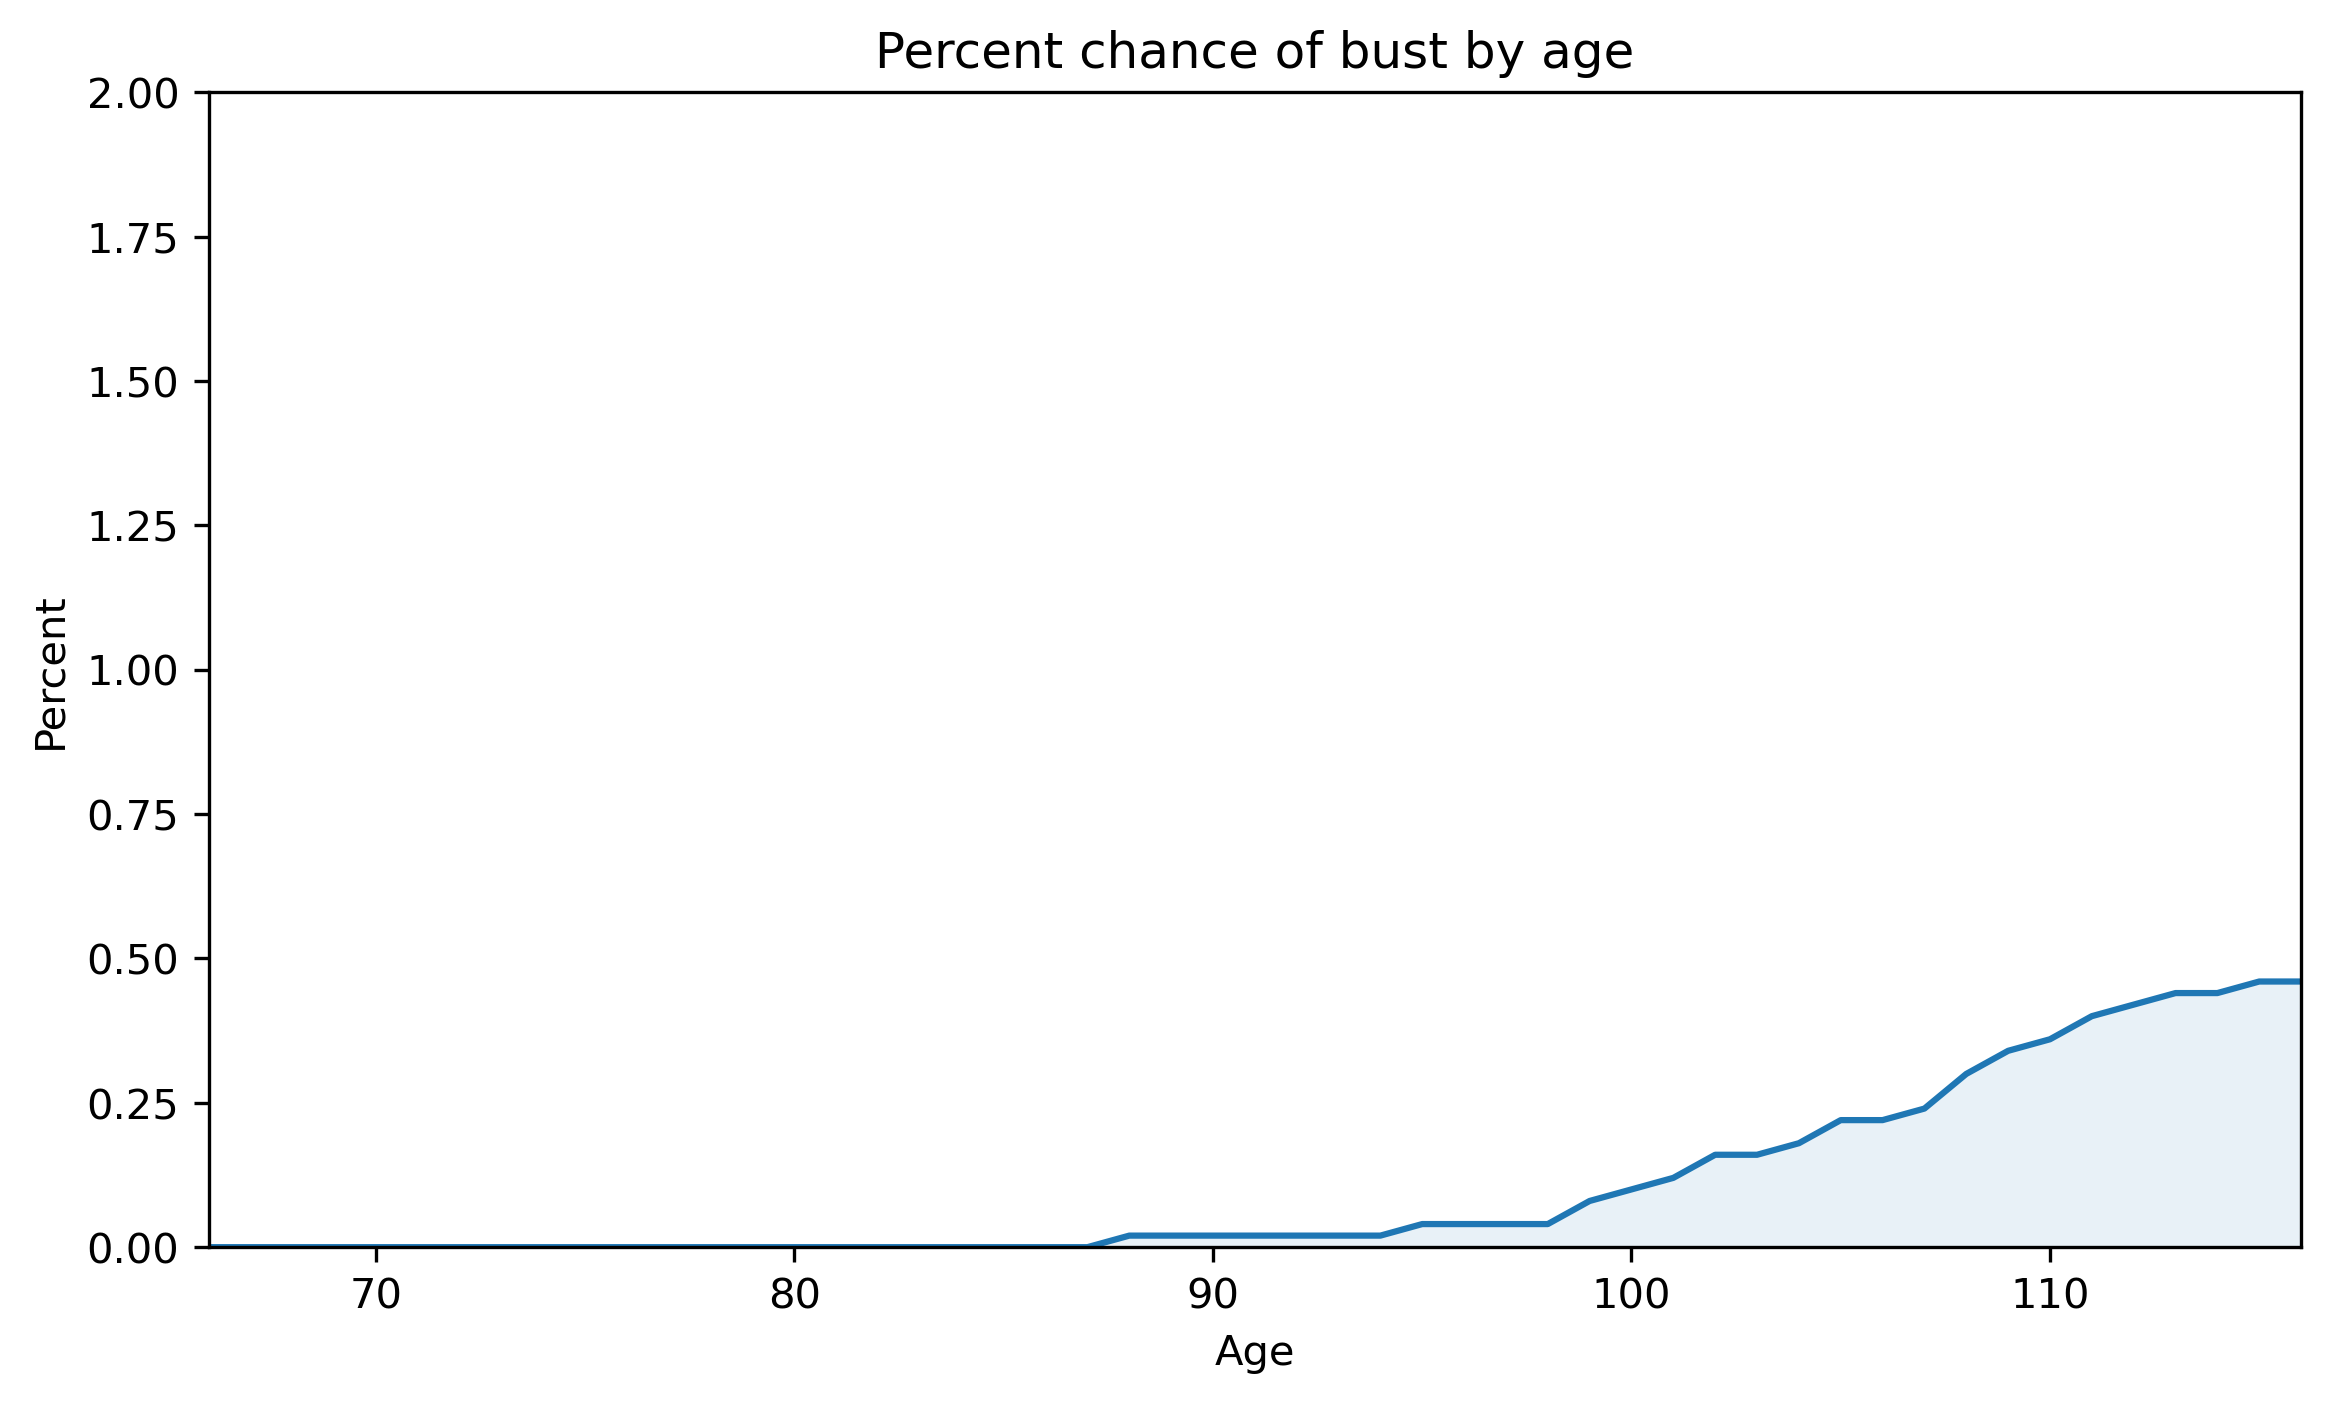

In [9]:
#plot probability of bust by age
plt.rcParams['figure.dpi'] = 300
plt.rcParams['legend.loc'] = 'upper left'
fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=bust_plot, x="age", y="bust",errorbar=None)
plt.fill_between(bust_plot.age.values, bust_plot.bust.values, alpha=.1)
ax.set_ylim(0,max(max(bust_plot['bust'])*1.1,2))
ax.set_xlim(min(bust_plot['age']),max(bust_plot['age']))
ax.set_xlabel('Age')
ax.set_ylabel('Percent')
ax.set_title('Percent chance of bust by age')
plt.show()

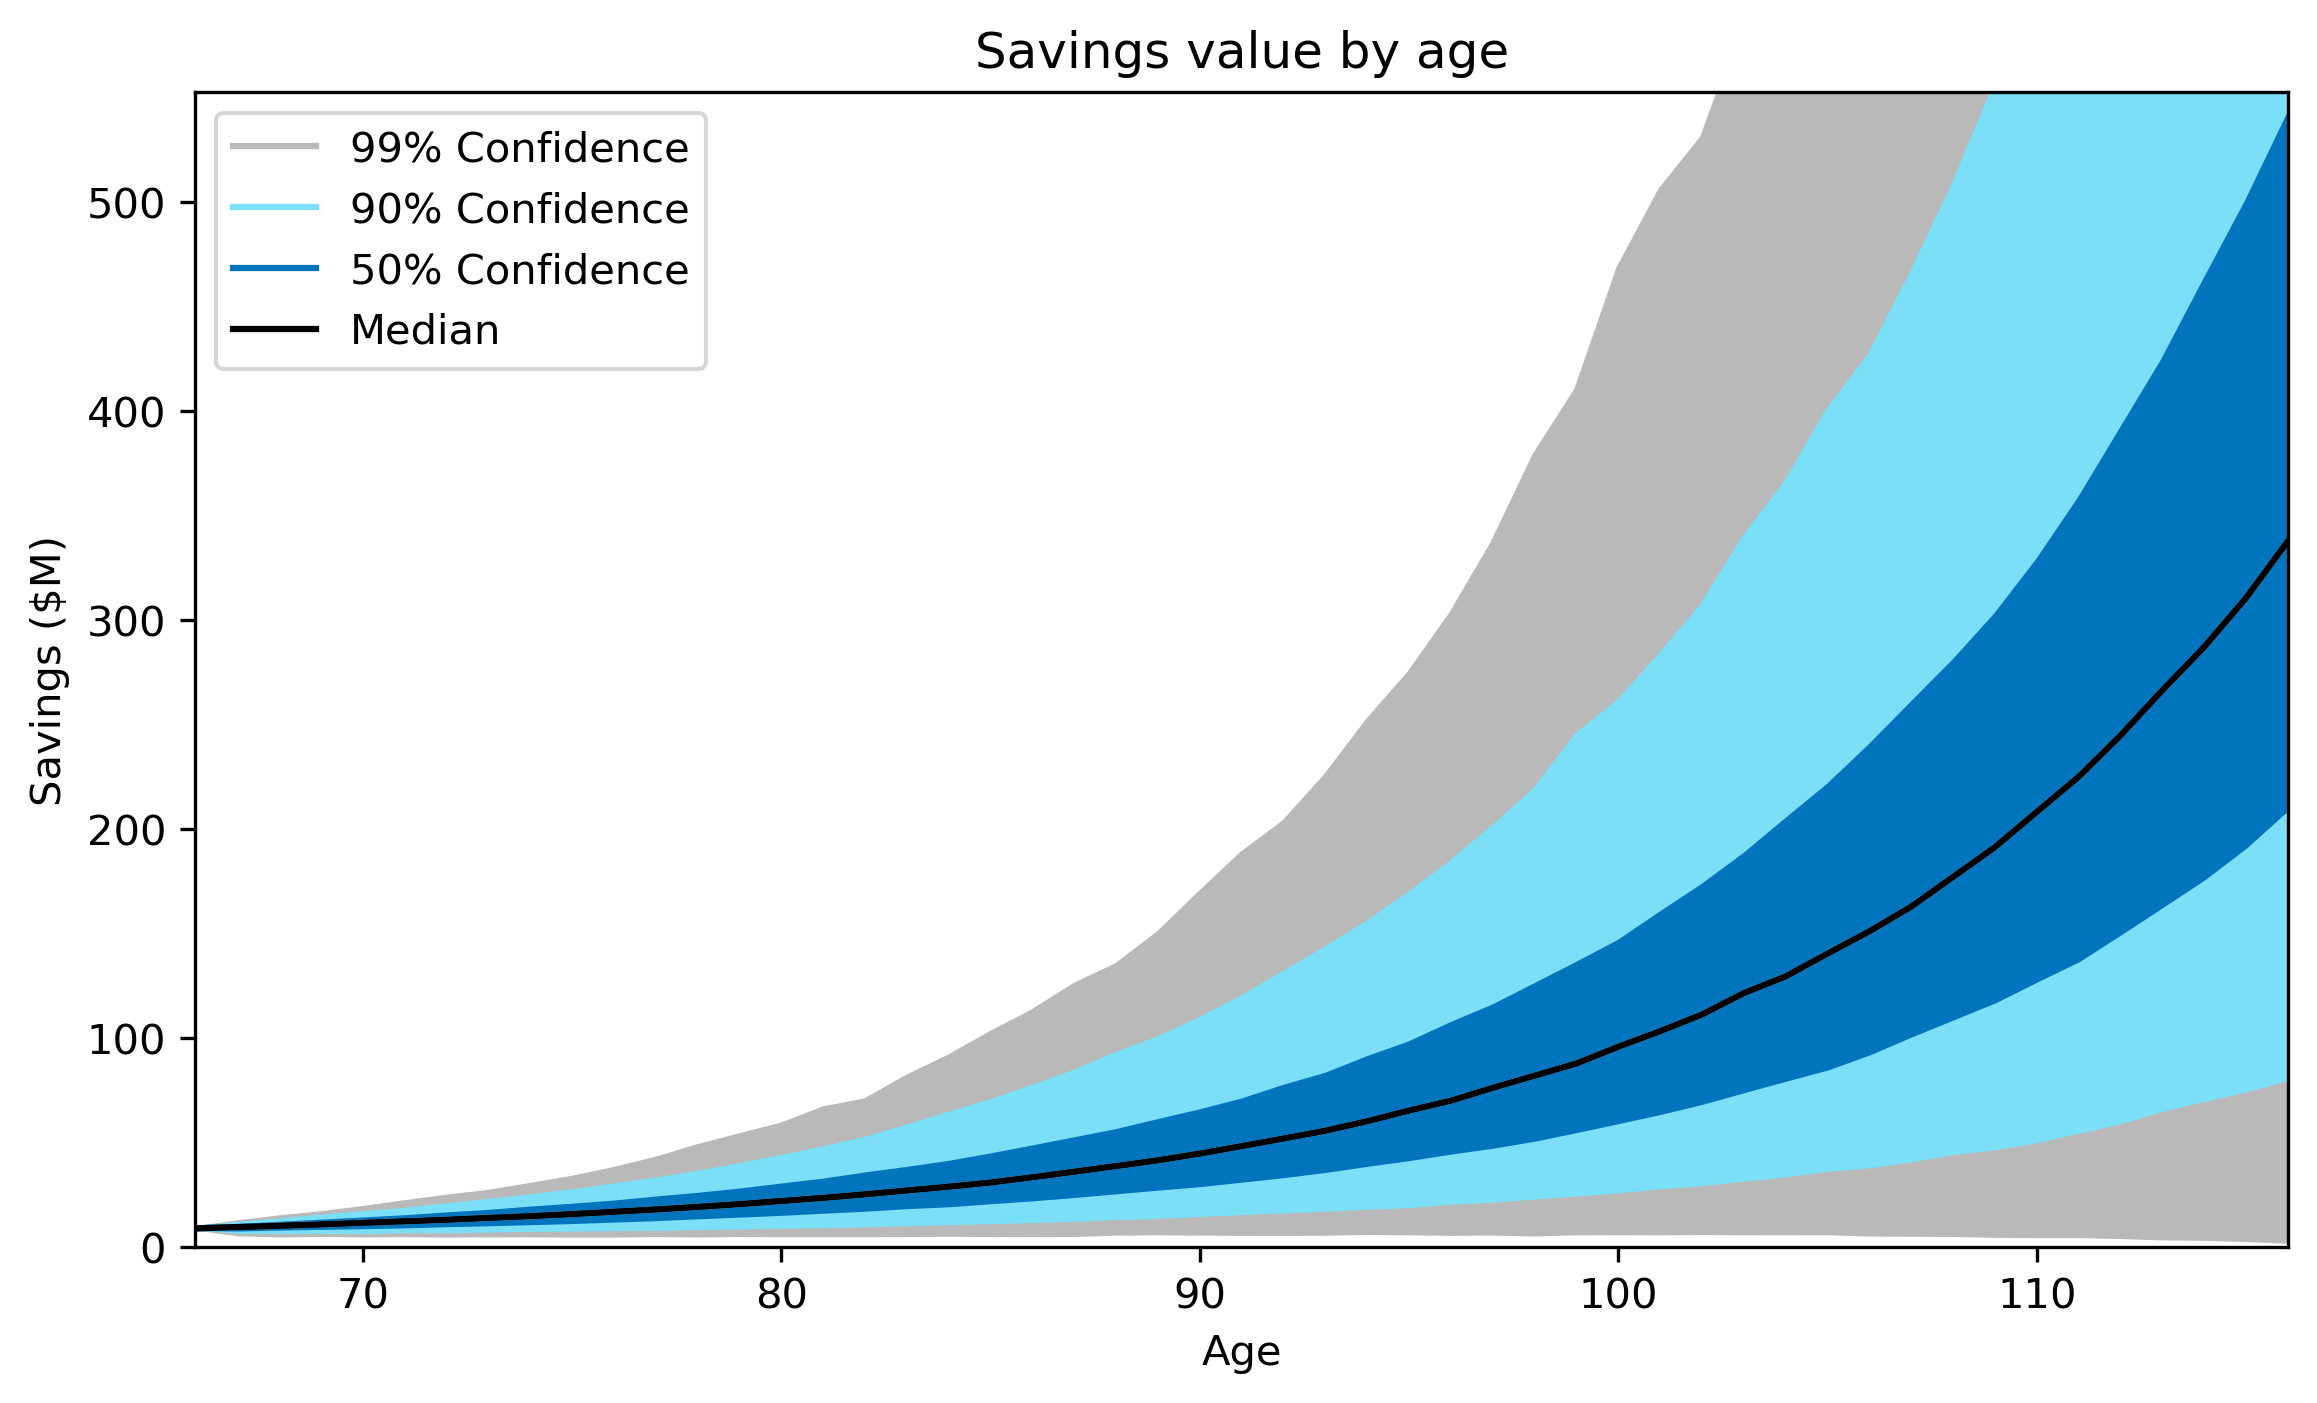

In [10]:
#plot savings value by age
fig, ax = plt.subplots(figsize=(9,5))
sns.lineplot(data=plotme, x="age", y="ending_savings",errorbar=('pi',99),
             estimator='median',color='#B9B9B9',err_kws={'alpha':1}, label="99% Confidence")
sns.lineplot(data=plotme, x="age", y="ending_savings",errorbar=('pi',90),
             estimator='median',color='#7BDFF7',err_kws={'alpha':1},label="90% Confidence")
sns.lineplot(data=plotme, x="age", y="ending_savings",errorbar=('pi',50),
             estimator='median',color='#0174BE',err_kws={'alpha':1}, label="50% Confidence")
sns.lineplot(data=plotme, x="age", y="ending_savings",color='k',
             alpha=1,errorbar=None,estimator='median', label="Median")

#make it pretty
max_y=max(plotme.groupby('age')['ending_savings'].quantile(.75))
ax.set_ylim(0,1.02*max_y)
ax.set_xlim(min(plotme['age']),max(plotme['age']))
ax.set_xlabel('Age')
ax.set_ylabel('Savings ($M)')
ax.set_title('Savings value by age')
plt.show()